**Clean Column Names**

In [93]:
import warnings

warnings.filterwarnings("ignore")

In [94]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2016.csv")

df.head(10)

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
4,0,6-25,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,...,Sometimes,Sometimes,43,Female,United States of America,Illinois,United States of America,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes
5,0,More than 1000,1.0,NaN,Yes,I am not sure,No,Yes,Yes,Somewhat easy,...,Not applicable to me,Often,42,Male,United Kingdom,NaN,United Kingdom,NaN,DevOps/SysAdmin|Support|Back-end Developer|Fro...,Sometimes
6,0,26-100,1.0,NaN,I don't know,No,No,No,I don't know,Somewhat easy,...,Not applicable to me,Not applicable to me,30,M,United States of America,Tennessee,United States of America,Tennessee,Back-end Developer,Sometimes
7,0,More than 1000,1.0,NaN,Yes,Yes,No,Yes,Yes,Very easy,...,Sometimes,Often,37,female,United States of America,Virginia,United States of America,Virginia,Dev Evangelist/Advocate|Back-end Developer,Always
8,0,26-100,0.0,1.0,I don't know,No,No,No,I don't know,Very difficult,...,Rarely,Often,44,Female,United States of America,California,United States of America,California,Support|Back-end Developer|One-person shop,Sometimes
9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Rarely,Often,30,Male,United States of America,Kentucky,United States of America,Kentucky,One-person shop|Front-end Developer|Back-end D...,Always


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

In [96]:
df.shape

(1433, 63)

In [97]:
df.values

array([[0, '26-100', 1.0, ..., nan, 'Back-end Developer', 'Sometimes'],
       [0, '6-25', 1.0, ..., 'Illinois',
        'Back-end Developer|Front-end Developer', 'Never'],
       [0, '6-25', 1.0, ..., nan, 'Back-end Developer', 'Always'],
       ...,
       [0, '100-500', 1.0, ..., 'Georgia', 'Back-end Developer',
        'Sometimes'],
       [0, '100-500', 0.0, ..., 'Nebraska', 'DevOps/SysAdmin',
        'Sometimes'],
       [0, '100-500', 1.0, ..., nan, 'Other', 'Sometimes']], dtype=object)

In [98]:
text_columns = df.select_dtypes(include='object').columns.tolist()

for col in text_columns:
    print(f"\n=== {col} ===")
    print(df[col].dropna().astype(str).head(3).to_string(index=False))



=== How many employees does your company or organization have? ===
26-100
  6-25
  6-25

=== Does your employer provide mental health benefits as part of healthcare coverage? ===
Not eligible for coverage / N/A
                             No
                             No

=== Do you know the options for mental health care available under your employer-provided coverage? ===
          Yes
          Yes
I am not sure

=== Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? ===
 No
Yes
 No

=== Does your employer offer resources to learn more about mental health concerns and options for seeking help? ===
 No
Yes
 No

=== Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer? ===
I don't know
         Yes
I don't know

=== If a mental health issue prompted you to request a medical leave from work, asking for that leav

In [99]:
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
#df = pd.read_csv("/mnt/data/OSMI Mental Health in Tech Survey 2016.csv")

# Columns to analyze
text_cols = [
    "Why or why not?",
    "Why or why not?.1",
    "If yes, what condition(s) have you been diagnosed with?",
    "If maybe, what condition(s) do you believe you have?",
    "If so, what condition(s) were you diagnosed with?"
]

# Filter dataframe
df_text = df[text_cols]

# Drop rows where all selected columns are null
df_text = df_text.dropna(how='all')

# Fill remaining NaNs with empty strings
df_text = df_text.fillna("")

# Text cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove digits
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply cleaning
for col in text_cols:
    df_text[col + "_cleaned"] = df_text[col].apply(clean_text)

# Combine cleaned text columns into one
df_text["combined_text"] = df_text[[col + "_cleaned" for col in text_cols]].agg(" ".join, axis=1)

# Apply VADER Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df_text["sentiment_score"] = df_text["combined_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Label sentiment
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_text["sentiment_label"] = df_text["sentiment_score"].apply(label_sentiment)

# Preview results
df_text[["combined_text", "sentiment_score", "sentiment_label"]].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,combined_text,sentiment_score,sentiment_label
0,anxiety disorder generalized social phobia...,-0.7184,Negative
1,would depend health issue health issue would i...,-0.9678,Negative
2,would provable need know judge job stigma main...,0.0000,Neutral
3,old back injury doesnt cause many issue occasi...,-0.9812,Negative
4,depending interview stage whether required acc...,0.0905,Positive


In [100]:
df_text.to_csv("cleaned_mental_health_2016.csv", index=False)
score2016 = df_text["sentiment_score"]

# Automatically find the column that contains 'country' in its name
country_col2016 = [col for col in df.columns if 'country' in col.lower() and 'live' in col.lower()]

# If found, assign the first match to a variable
if country_col2016:
    country_data2016 = df[country_col2016[0]]
    print(f"Found country column: {country_col2016[0]}")
else:
    print("No column containing 'country' found.")

Found country column: What country do you live in?


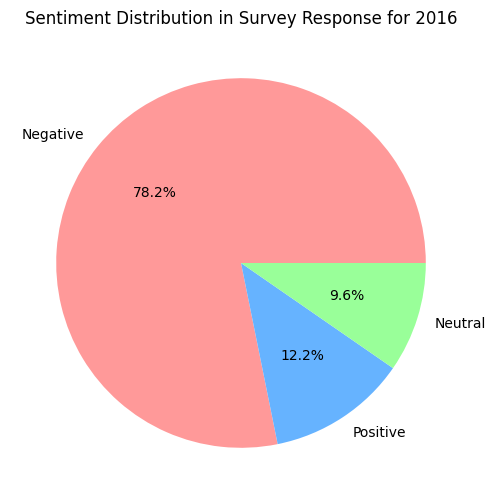

In [101]:
import matplotlib.pyplot as plt

# Count each sentiment label
sentiment_counts = df_text["sentiment_label"].value_counts()

# Plot
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment Distribution in Survey Response for 2016")
plt.show()


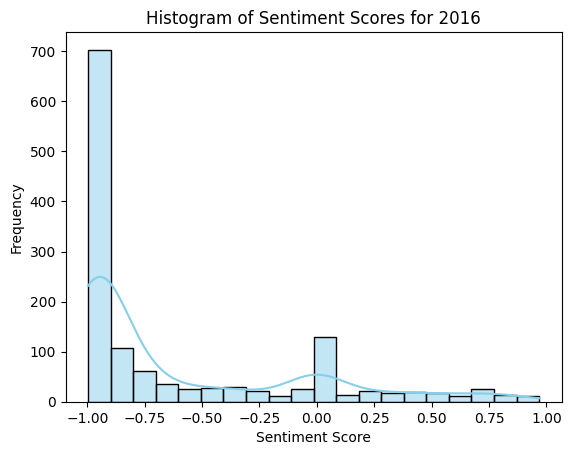

In [102]:
import seaborn as sns

sns.histplot(data=df_text, x="sentiment_score", bins=20, kde=True, color='skyblue')

plt.title("Histogram of Sentiment Scores for 2016")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [103]:
df2 = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2017.csv")

df2.head()

,#,<strong>Are you self-employed?</strong>,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided health coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,...,What is your gender?,What country do you <strong>live</strong> in?,What US state or territory do you <strong>live</strong> in?,What is your race?,Other.3,What country do you <strong>work</strong> in?,What US state or territory do you <strong>work</strong> in?,Start Date (UTC),Submit Date (UTC),Network ID
0,e49fe87572831232dcfa51b376b22039,0,100-500,1.0,1.0,No,Yes,No,I don't know,I don't know,...,Female,United Kingdom,NaN,NaN,NaN,United Kingdom,NaN,2018-05-16 12:32:04,2018-05-16 12:42:40,464b7a12f1
1,a1eede444ac024928d247a8372d54931,0,100-500,1.0,1.0,Yes,Yes,No,No,I don't know,...,male,United Kingdom,NaN,NaN,NaN,United Kingdom,NaN,2018-05-16 12:31:13,2018-05-16 12:40:40,464b7a12f1
2,37d3fd67f62bd1e0a2dea4f9cd440d98,0,6-25,1.0,1.0,I don't know,No,I don't know,No,Yes,...,male,United States of America,Missouri,White,NaN,United States of America,Missouri,2018-05-09 05:34:05,2018-05-09 05:46:04,1eb7e0cb94
3,519b759442c1cab0e9b5a8a1acb1b216,0,More than 1000,1.0,1.0,Yes,Yes,I don't know,I don't know,Yes,...,Male,United States of America,Washington,White,NaN,United States of America,Washington,2018-05-04 23:19:14,2018-05-04 23:23:23,63852edbc4
4,ef0af4927b575b1a3e607c11ca37870e,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,female,United States of America,Illinois,More than one of the above,NaN,United States of America,Illinois,2018-05-03 00:40:24,2018-05-03 00:53:20,43237889f1


In [104]:
df2.describe()

,<strong>Are you self-employed?</strong>,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Have you ever discussed your mental health with your employer?,Have you ever discussed your mental health with coworkers?,Have you ever had a coworker discuss their or another coworker's mental health with you?,"Overall, how much importance does your employer place on physical health?","Overall, how much importance does your employer place on mental health?",Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?,<strong>Do you have previous employers?</strong>,...,Have you ever sought treatment for a mental health disorder from a mental health professional?,How willing would you be to share with friends and family that you have a mental illness?,Are you openly identified at work as a person with a mental health issue?,Has being identified as a person with a mental health issue affected your career?,How has it affected your career?,"If they knew you suffered from a mental health disorder, how do you think that team members/co-workers would react?",Describe the circumstances of the supportive or well handled response.,"Overall, how well do you think the tech industry supports employees with mental health issues?",Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used <em>anonymously</em> and only with your permission.),What is your age?
count,756.000000,643.000000,643.00000,643.000000,643.000000,638.000000,643.000000,643.000000,113.000000,756.000000,...,756.000000,756.000000,754.000000,84.000000,26.000000,754.000000,0.0,754.000000,754.000000,754.000000
mean,0.149471,0.779160,0.92535,0.320373,0.451011,0.490596,6.373250,5.130638,0.699115,0.882275,...,0.603175,6.362434,0.114058,0.309524,4.153846,5.336870,NaN,2.534483,0.330239,34.988064
std,0.356788,0.415136,0.26303,0.466983,0.497982,0.500304,2.223641,2.400359,0.460686,0.322495,...,0.489563,2.769917,0.318093,0.465074,2.633512,2.184223,NaN,0.914400,0.470611,8.338051
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,18.000000
25%,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,5.000000,3.500000,0.000000,1.000000,...,0.000000,5.000000,0.000000,0.000000,2.000000,4.000000,NaN,2.000000,0.000000,29.000000
50%,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,7.000000,5.000000,1.000000,1.000000,...,1.000000,7.000000,0.000000,0.000000,3.000000,5.000000,NaN,3.000000,0.000000,34.000000
75%,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,8.000000,7.000000,1.000000,1.000000,...,1.000000,9.000000,0.000000,1.000000,6.000000,7.000000,NaN,3.000000,1.000000,40.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,10.000000,10.000000,1.000000,1.000000,...,1.000000,10.000000,1.000000,1.000000,10.000000,10.000000,NaN,5.000000,1.000000,67.000000


In [105]:
text_columns = df2.select_dtypes(include='object').columns.tolist()

for col in text_columns:
    print(f"\n=== {col} ===")
    print(df2[col].dropna().astype(str).head(3).to_string(index=False))



=== # ===
e49fe87572831232dcfa51b376b22039
a1eede444ac024928d247a8372d54931
37d3fd67f62bd1e0a2dea4f9cd440d98

=== How many employees does your company or organization have? ===
100-500
100-500
   6-25

=== Does your employer provide mental health benefits as part of healthcare coverage? ===
          No
         Yes
I don't know

=== Do you know the options for mental health care available under your employer-provided health coverage? ===
Yes
Yes
 No

=== Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? ===
          No
          No
I don't know

=== Does your employer offer resources to learn more about mental health disorders and options for seeking help? ===
I don't know
          No
          No

=== Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer? ===
I don't know
I don't know
         Yes

=== If a men

In [106]:
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2017.csv")

# Columns to analyze (open-ended responses)
text_cols = [
    "Why or why not?",
    "Why or why not?.1",
    "Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",
    "Describe the conversation with coworkers you had about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names).",
    "Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",
    "Describe the conversation you had with your previous coworkers about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names)..1",
    "Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.",
    "Describe the circumstances of the badly handled or unsupportive response.",
    "If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so."
]

# Filter dataframe
df_text2 = df[text_cols]

# Drop rows where all selected columns are null
df_text2 = df_text2.dropna(how='all')

# Fill remaining NaNs with empty strings
df_text2 = df_text2.fillna("")

# Text cleaning setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Clean text for each column
for col in text_cols:
    df_text2[col + "_cleaned"] = df_text2[col].apply(clean_text)

# Combine all cleaned text into one column
df_text2["combined_text"] = df_text2[[col + "_cleaned" for col in text_cols]].agg(" ".join, axis=1)

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df_text2["sentiment_score"] = df_text2["combined_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Convert compound score to sentiment labels
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_text2["sentiment_label"] = df_text2["sentiment_score"].apply(label_sentiment)

# Preview top 10 rows
df_text2[["combined_text", "sentiment_score", "sentiment_label"]].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,combined_text,sentiment_score,sentiment_label
0,id worried wouldnt hire spoke anxiety suppor...,0.0093,Neutral
1,may require specific measure accomodate need m...,-0.8074,Negative
2,sometimes bring psoriasis explanation flare we...,-0.9001,Negative
3,anything may hurt chance hired going provided ...,-0.0828,Negative
4,depends something start interview get job firs...,0.4809,Positive
5,would depend wouldnt feel safe awareness...,-0.3412,Negative
6,seems like would distraction would worried wou...,0.8591,Positive
7,want maintain privacy unless end physical heal...,0.3612,Positive
8,fear getting job fear getting job dont k...,-0.7506,Negative
9,ok ok ok ok ok ok ok,0.9081,Positive


In [107]:
df_text2.to_csv("cleaned_mental_health_2017.csv", index=False)
score2017 = df_text2["sentiment_score"]

# Automatically find the column that contains 'country' in its name
country_col2017 = [col for col in df.columns if 'country' in col.lower() and 'live' in col.lower()]

# If found, assign the first match to a variable
if country_col2017:
    country_data2017 = df[country_col2017[0]]
    print(f"Found country column: {country_col2017[0]}")
else:
    print("No column containing 'country' found.")

Found country column: What country do you <strong>live</strong> in?


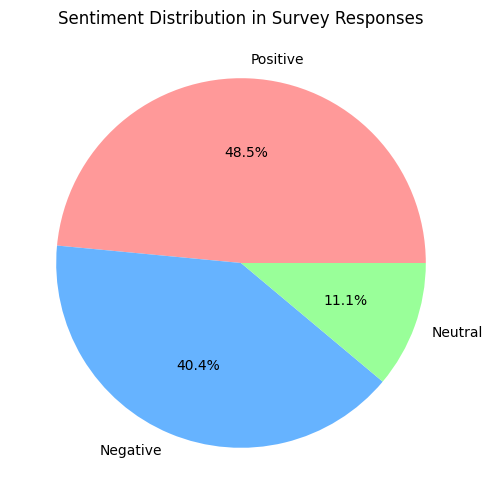

In [108]:
# Count each sentiment label
sentiment_counts = df_text2["sentiment_label"].value_counts()

# Plot
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment Distribution in Survey Responses")
plt.show()


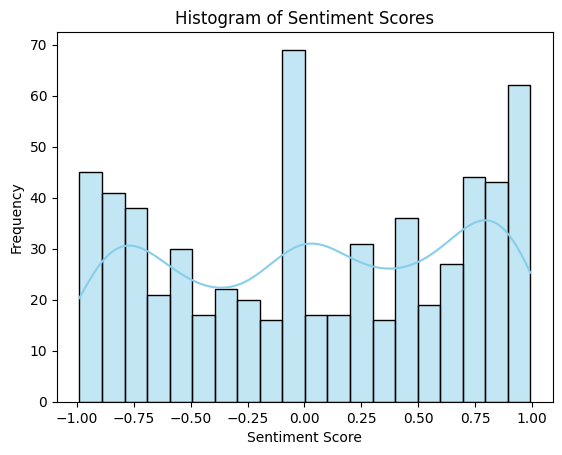

In [109]:
sns.histplot(data=df_text2, x="sentiment_score", bins=20, kde=True, color='skyblue')

plt.title("Histogram of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [110]:
df3 = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2018.csv")

df3.head(10)

,#,<strong>Are you self-employed?</strong>,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided health coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,...,What is your gender?,What country do you <strong>live</strong> in?,What US state or territory do you <strong>live</strong> in?,What is your race?,Other.3,What country do you <strong>work</strong> in?,What US state or territory do you <strong>work</strong> in?,Start Date (UTC),Submit Date (UTC),Network ID
0,e44a0a34f2465940beda2a1537e9b99e,0,More than 1000,1.0,0.0,Yes,Yes,Yes,Yes,Yes,...,Female,Canada,NaN,NaN,NaN,Canada,NaN,2018-12-29 23:46:38,2018-12-30 00:00:03,4bbb884ccc
1,0d698e3beca20fb75f19b9d528e36d73,0,More than 1000,1.0,1.0,Yes,Yes,No,I don't know,I don't know,...,male,United States of America,Massachusetts,White,NaN,United States of America,Massachusetts,2018-12-27 21:40:40,2018-12-27 21:45:45,275e7543bd
2,61a40c9071eb36fa9caa254d31500c41,0,6-25,0.0,1.0,Yes,Yes,No,No,I don't know,...,Male,United States of America,Florida,White,NaN,United States of America,Florida,2018-12-21 17:37:43,2018-12-21 18:08:01,43994c3dba
3,f8624340bead7deb08abb766704ddf6b,0,6-25,1.0,1.0,No,No,No,No,I don't know,...,male,Norway,NaN,NaN,NaN,Norway,NaN,2018-12-21 16:37:56,2018-12-21 16:44:44,907b3a3faa
4,31d3ae93b68d79e504a0a643601b6b1e,0,26-100,1.0,1.0,Yes,Yes,Yes,Yes,Yes,...,Ostensibly Male,United States of America,Tennessee,White,NaN,United States of America,Tennessee,2018-12-20 19:39:02,2018-12-20 20:58:34,26df20fea3
5,7cf45fb3b9d4e59f861b9b25805ec2c1,0,100-500,1.0,1.0,Yes,Yes,No,I don't know,I don't know,...,male,United States of America,South Carolina,White,NaN,United States of America,South Carolina,2018-12-20 15:04:07,2018-12-20 15:11:04,82a0eebd93
6,db11ff1cd3c2d2c2cf8fe3e2400dc351,0,More than 1000,1.0,1.0,Yes,Yes,No,No,I don't know,...,Agender,Finland,NaN,NaN,NaN,Finland,NaN,2018-12-20 01:33:40,2018-12-20 01:38:38,9aa60d483b
7,c7001583699c208ccf02219865770f4d,0,26-100,1.0,1.0,Not eligible for coverage / NA,NaN,No,No,I don't know,...,male,Poland,NaN,NaN,NaN,Poland,NaN,2018-12-19 22:21:16,2018-12-19 22:33:57,f1b69c6ddc
8,ebf2903ac77f9f7a0ae55f18df2c7804,0,More than 1000,1.0,1.0,I don't know,No,No,No,No,...,"male, born with xy chromosoms",Russia,NaN,NaN,NaN,Russia,NaN,2018-12-17 12:22:37,2018-12-17 12:42:30,068865d243
9,74815c98f7b64396dbc82fe06cc1fb31,0,More than 1000,0.0,1.0,Yes,No,No,Yes,I don't know,...,Male,United States of America,Iowa,White,NaN,United States of America,Iowa,2018-12-15 13:52:30,2018-12-15 14:05:42,56b48c1a97


In [111]:
text_columns = df3.select_dtypes(include='object').columns.tolist()

for col in text_columns:
    print(f"\n=== {col} ===")
    print(df3[col].dropna().astype(str).head(3).to_string(index=False))



=== # ===
e44a0a34f2465940beda2a1537e9b99e
0d698e3beca20fb75f19b9d528e36d73
61a40c9071eb36fa9caa254d31500c41

=== How many employees does your company or organization have? ===
More than 1000
More than 1000
          6-25

=== Does your employer provide mental health benefits as part of healthcare coverage? ===
Yes
Yes
Yes

=== Do you know the options for mental health care available under your employer-provided health coverage? ===
Yes
Yes
Yes

=== Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? ===
Yes
 No
 No

=== Does your employer offer resources to learn more about mental health disorders and options for seeking help? ===
         Yes
I don't know
          No

=== Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer? ===
         Yes
I don't know
I don't know

=== If a mental health issue prompted you to 

In [112]:
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2018.csv")

# Columns to analyze (open-ended responses)
text_cols = [
    "Why or why not?",
    "Why or why not?.1",
    "Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",
    "Describe the conversation with coworkers you had about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names).",
    "Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",
    "Describe the conversation you had with your previous coworkers about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names)..1",
    "Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.",
    "Describe the circumstances of the badly handled or unsupportive response.",
    "If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so."
]

# Filter dataframe
df_text2 = df[text_cols]

# Drop rows where all selected columns are null
df_text2 = df_text2.dropna(how='all')

# Fill remaining NaNs with empty strings
df_text2 = df_text2.fillna("")

# Text cleaning setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Clean text for each column
for col in text_cols:
    df_text2[col + "_cleaned"] = df_text2[col].apply(clean_text)

# Combine all cleaned text into one column
df_text2["combined_text"] = df_text2[[col + "_cleaned" for col in text_cols]].agg(" ".join, axis=1)

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df_text2["sentiment_score"] = df_text2["combined_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Convert compound score to sentiment labels
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_text2["sentiment_label"] = df_text2["sentiment_score"].apply(label_sentiment)

# Preview top 10 rows
df_text2[["combined_text", "sentiment_score", "sentiment_label"]].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,combined_text,sentiment_score,sentiment_label
0,dont see relevant relevant informed employer s...,0.6908,Positive
1,least sure would affect chance getting job ...,0.4689,Positive
2,wouldnt bring unless would potentially impact ...,0.9780,Positive
4,know need expect cant meet good fit hey lot a...,-0.7018,Negative
5,like open honest like open honest coworker s...,0.5859,Positive
7,would afraid went fine person talked one d...,0.4588,Positive
8,mentioned seasonal allergy interview declined ...,-0.8239,Negative
9,excluded excluded overview talk criticism,-0.7717,Negative
10,worked top field two decade hidden physical di...,-0.4404,Negative
11,normalordinary talk physical health issue prob...,0.1027,Positive


In [113]:
df_text2.to_csv("cleaned_mental_health_2018.csv", index=False)
score2018 = df_text2["sentiment_score"]

# Automatically find the column that contains 'country' in its name
country_col2018 = [col for col in df.columns if 'country' in col.lower() and 'live' in col.lower()]

# If found, assign the first match to a variable
if country_col2018:
    country_data2018 = df[country_col2018[0]]
    print(f"Found country column: {country_col2018[0]}")
else:
    print("No column containing 'country' found.")

Found country column: What country do you <strong>live</strong> in?


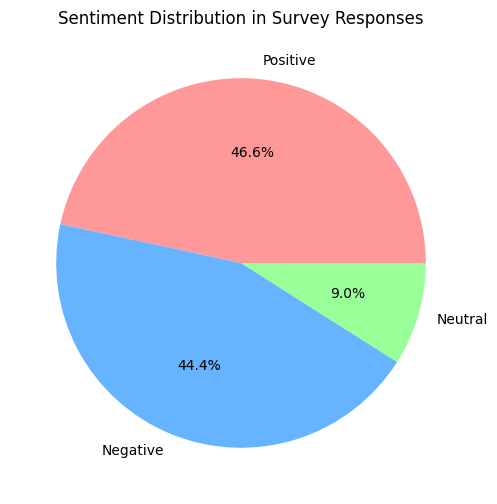

In [114]:
# Count each sentiment label
sentiment_counts = df_text2["sentiment_label"].value_counts()

# Plot
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment Distribution in Survey Responses")
plt.show()


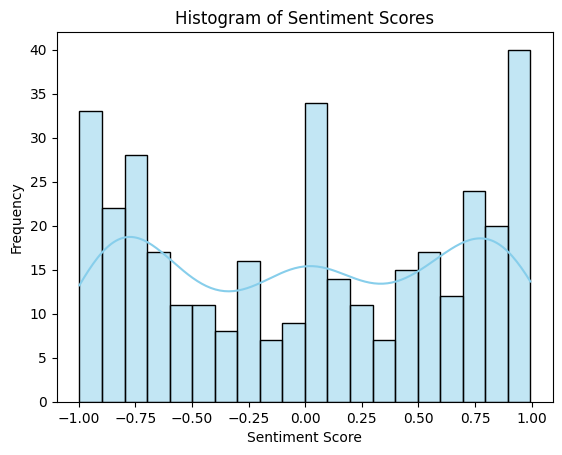

In [115]:
sns.histplot(data=df_text2, x="sentiment_score", bins=20, kde=True, color='skyblue')

plt.title("Histogram of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [116]:
df4 = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2019.csv")

df4.head(10)

,*Are you self-employed?*,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided health coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?",...,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,"If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.",Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.),What is your age?,What is your gender?,What country do you *live* in?,What US state or territory do you *live* in?,What is your race?,What country do you *work* in?,What US state or territory do you *work* in?
0,False,26-100,True,True,I don't know,No,Yes,Yes,I don't know,Very easy,...,NaN,NaN,False,25,Male,United States of America,Nebraska,White,United States of America,Nebraska
1,False,26-100,True,True,Yes,No,No,Yes,Yes,I don't know,...,NaN,NaN,False,51,male,United States of America,Nebraska,White,United States of America,Nebraska
2,False,26-100,True,True,I don't know,No,No,I don't know,I don't know,Somewhat difficult,...,I think opening up more conversation around th...,Thank you,True,27,Male,United States of America,Illinois,White,United States of America,Illinois
3,False,100-500,True,True,I don't know,No,Yes,Yes,Yes,Very easy,...,NaN,NaN,False,37,male,United States of America,Nebraska,White,United States of America,Nebraska
4,False,26-100,True,True,I don't know,No,I don't know,I don't know,I don't know,I don't know,...,NaN,NaN,False,46,m,United States of America,Nebraska,White,United States of America,Nebraska
5,False,100-500,True,False,Yes,No,No,No,I don't know,Somewhat difficult,...,NaN,NaN,False,36,female,United States of America,Nebraska,White,United States of America,Nebraska
6,False,26-100,True,True,Yes,Yes,No,I don't know,Yes,Somewhat easy,...,Emphasize more on whole person health as an im...,NaN,False,39,Female,United States of America,Nebraska,White,United States of America,Nebraska
7,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Too many people use OCD and ADHD as jokes to d...,NaN,False,35,Male,United States of America,Wisconsin,White,United States of America,Wisconsin
8,False,26-100,True,True,Yes,No,Yes,Yes,Yes,Very easy,...,Provide support and educate from the top down ...,NaN,False,49,NaN,United Kingdom,NaN,NaN,United Kingdom,NaN
9,False,6-25,True,True,I don't know,NaN,No,I don't know,I don't know,Somewhat easy,...,NaN,NaN,False,45,Male,United Kingdom,NaN,NaN,United Kingdom,NaN


In [117]:
text_columns = df4.select_dtypes(include='object').columns.tolist()

for col in text_columns:
    print(f"\n=== {col} ===")
    print(df4[col].dropna().astype(str).head(3).to_string(index=False))



=== How many employees does your company or organization have? ===
26-100
26-100
26-100

=== Is your employer primarily a tech company/organization? ===
True
True
True

=== Is your primary role within your company related to tech/IT? ===
True
True
True

=== Does your employer provide mental health benefits as part of healthcare coverage? ===
I don't know
         Yes
I don't know

=== Do you know the options for mental health care available under your employer-provided health coverage? ===
No
No
No

=== Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? ===
Yes
 No
 No

=== Does your employer offer resources to learn more about mental health disorders and options for seeking help? ===
         Yes
         Yes
I don't know

=== Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer? ===
I don't know
         Yes
I do

In [118]:
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2019.csv")

# Columns to analyze (open-ended responses)
text_cols = [
    "Why or why not?",
    "Why or why not?.1",
    "Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",
    "Describe the conversation with coworkers you had about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names).",
    "Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",
    "Describe the conversation you had with your previous coworkers about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names)..1",
    "Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.",
    "Describe the circumstances of the badly handled or unsupportive response.",
    "If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so."
]

# Filter dataframe
df_text2 = df[text_cols]

# Drop rows where all selected columns are null
df_text2 = df_text2.dropna(how='all')

# Fill remaining NaNs with empty strings
df_text2 = df_text2.fillna("")

# Text cleaning setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Clean text for each column
for col in text_cols:
    df_text2[col + "_cleaned"] = df_text2[col].apply(clean_text)

# Combine all cleaned text into one column
df_text2["combined_text"] = df_text2[[col + "_cleaned" for col in text_cols]].agg(" ".join, axis=1)

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df_text2["sentiment_score"] = df_text2["combined_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Convert compound score to sentiment labels
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_text2["sentiment_label"] = df_text2["sentiment_score"].apply(label_sentiment)

# Preview top 10 rows
df_text2[["combined_text", "sentiment_score", "sentiment_label"]].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,combined_text,sentiment_score,sentiment_label
0,impact work would bring feel control likely wo...,0.0078,Neutral
1,trust potential employer would remain unbiased...,0.8860,Positive
2,depends applicability job detrimental could st...,0.6692,Positive
3,discriminationbias discriminationbias,0.0000,Neutral
5,wouldnt want risk getting job wouldnt want ris...,-0.7364,Negative
6,would safety issue disclose information awaren...,-0.7497,Negative
7,physical issue would make miss work regularly ...,0.6369,Positive
8,depends talking knowledge supportive text con...,0.8591,Positive
9,stressed project affecting work,-0.3400,Negative
11,usually relatively simple adjust physical limi...,-0.6486,Negative


In [119]:
df_text2.to_csv("cleaned_mental_health_2019.csv", index=False)
score2019 = df_text2["sentiment_score"]

# Automatically find the column that contains 'country' in its name
country_col2019 = [col for col in df.columns if 'country' in col.lower() and 'live' in col.lower()]

# If found, assign the first match to a variable
if country_col2019:
    country_data2019 = df[country_col2019[0]]
    print(f"Found country column: {country_col2019[0]}")
else:
    print("No column containing 'country' found.")

Found country column: What country do you *live* in?


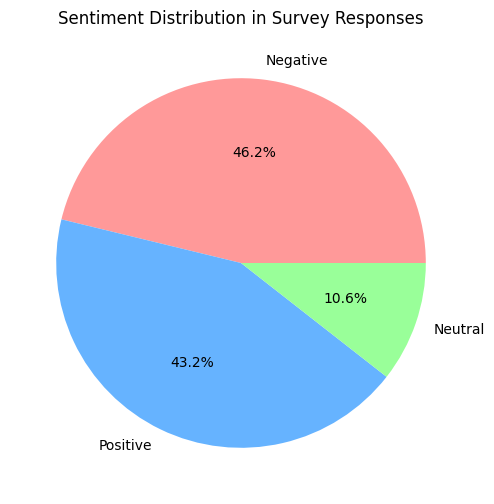

In [120]:
# Count each sentiment label
sentiment_counts = df_text2["sentiment_label"].value_counts()

# Plot
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment Distribution in Survey Responses")
plt.show()


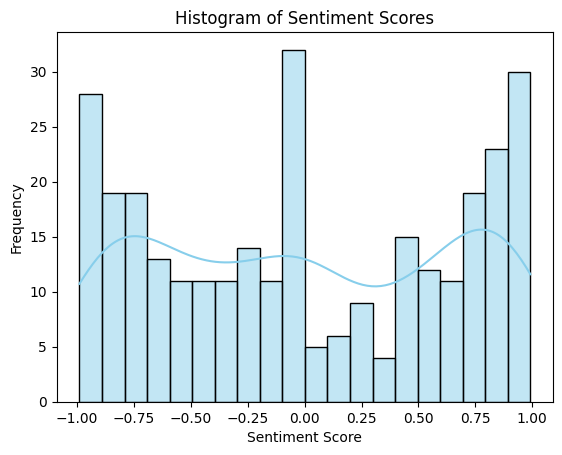

In [121]:
sns.histplot(data=df_text2, x="sentiment_score", bins=20, kde=True, color='skyblue')

plt.title("Histogram of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [122]:
df5 = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2020 .csv")

df5.head(10)

,#,*Are you self-employed?*,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided health coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,...,"If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.",Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.),What is your age?,What is your gender?,What country do you *live* in?,What US state or territory do you *live* in?,What is your race?,Other.3,What country do you *work* in?,What US state or territory do you *work* in?
0,zwrffw6ykfo82ft1twvzwrffw6c6wsfv,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,45,Male,United States of America,Connecticut,White,NaN,United States of America,Connecticut
1,zhdmhaa8r0125c4zmoi7qzhdmtjrakhm,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,24,female,Russia,NaN,NaN,NaN,Russia,NaN
2,x4itwa9hnlw7qke4y5xibx4itwa9yzl5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mental health should be a law by government.,1,46,Male,India,NaN,NaN,NaN,India,NaN
3,x3v3oimu5pn0043n8x3v3oizaybhwwto,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,25,Female,Canada,NaN,NaN,NaN,Canada,NaN
4,uyp6re7bhnyx6gez09uyp6re72z0e4e4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,no,1,25,F,Canada,NaN,NaN,NaN,Canada,NaN
5,u0nbmruq4qexmkk8zvqsu0nbmrh6he0e,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ryry,1,5,f,United States of America,Alabama,Asian,NaN,United States of America,Alabama
6,t4ck9zq73fzi90rtcfgzu0ot4ck9zzub,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,NaN,Japan,NaN,NaN,NaN,Afghanistan,NaN
7,sics80avlof5gljw4fqrl7sics805x6i,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,35,Male,United States of America,Minnesota,White,NaN,United States of America,Minnesota
8,rd0ztpn1g47k7bhehrd0ztt4hk3qv0kp,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"family background, and personal responsibilites",0,34,female,Ireland,NaN,NaN,NaN,Ireland,NaN
9,qxhj26vbyd7zlgbi1xqxhj26nalmk3sa,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,23,Female,Turkey,NaN,NaN,NaN,Turkey,NaN


In [123]:
text_columns = df4.select_dtypes(include='object').columns.tolist()

for col in text_columns:
    print(f"\n=== {col} ===")
    print(df4[col].dropna().astype(str).head(3).to_string(index=False))



=== How many employees does your company or organization have? ===
26-100
26-100
26-100

=== Is your employer primarily a tech company/organization? ===
True
True
True

=== Is your primary role within your company related to tech/IT? ===
True
True
True

=== Does your employer provide mental health benefits as part of healthcare coverage? ===
I don't know
         Yes
I don't know

=== Do you know the options for mental health care available under your employer-provided health coverage? ===
No
No
No

=== Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? ===
Yes
 No
 No

=== Does your employer offer resources to learn more about mental health disorders and options for seeking help? ===
         Yes
         Yes
I don't know

=== Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer? ===
I don't know
         Yes
I do

In [124]:
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("/kaggle/input/mental-health-in-tech-dashboard-2016-to-2020/OSMI Mental Health in Tech Survey 2020 .csv")

# Columns to analyze (open-ended responses)
text_cols = [
    "Why or why not?",
    "Why or why not?.1",
    "Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",
    "Describe the conversation with coworkers you had about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names).",
    "Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",
    "Describe the conversation you had with your previous coworkers about your mental health including their reactions.",
    "Describe the conversation your coworker had with you about their mental health (please do not use names)..1",
    "Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.",
    "Describe the circumstances of the badly handled or unsupportive response.",
    "If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so."
]

# Filter dataframe
df_text2 = df[text_cols]

# Drop rows where all selected columns are null
df_text2 = df_text2.dropna(how='all')

# Fill remaining NaNs with empty strings
df_text2 = df_text2.fillna("")

# Text cleaning setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Clean text for each column
for col in text_cols:
    df_text2[col + "_cleaned"] = df_text2[col].apply(clean_text)

# Combine all cleaned text into one column
df_text2["combined_text"] = df_text2[[col + "_cleaned" for col in text_cols]].agg(" ".join, axis=1)

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df_text2["sentiment_score"] = df_text2["combined_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Convert compound score to sentiment labels
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_text2["sentiment_label"] = df_text2["sentiment_score"].apply(label_sentiment)

# Preview top 10 rows
df_text2[["combined_text", "sentiment_score", "sentiment_label"]].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,combined_text,sentiment_score,sentiment_label
0,depend discussion would impact employment reas...,0.3612,Positive
2,affect employment job affect job underst...,0.0000,Neutral
4,affect another person affect personality perso...,0.4173,Positive
5,gryry ytuu thyt thyu ryry,0.0000,Neutral
7,physical disability understood well protected ...,0.6182,Positive
8,taking leave impact impression need cons...,0.4588,Positive
9,want side get wrong thought think people ment...,0.6249,Positive
10,dont want become defining feature stigma seen ...,-0.0829,Negative
11,disclosing physical health issue would harm ch...,0.7964,Positive
12,would need accomodation flex timework home app...,-0.1531,Negative


In [125]:
df_text2.to_csv("cleaned_mental_health_2020.csv", index=False)
score2020 = df_text2["sentiment_score"]
# Automatically find the column that contains 'country' in its name
country_col2020 = [col for col in df.columns if 'country' in col.lower() and 'live' in col.lower()]

# If found, assign the first match to a variable
if country_col2020:
    country_data2020 = df[country_col2020[0]]
    print(f"Found country column: {country_col2020[0]}")
else:
    print("No column containing 'country' found.")


Found country column: What country do you *live* in?


In [126]:
country_data2020

0      United States of America
1                        Russia
2                         India
3                        Canada
4                        Canada
                 ...           
175    United States of America
176                 Philippines
177    United States of America
178                      Canada
179                 Netherlands
Name: What country do you *live* in?, Length: 180, dtype: object

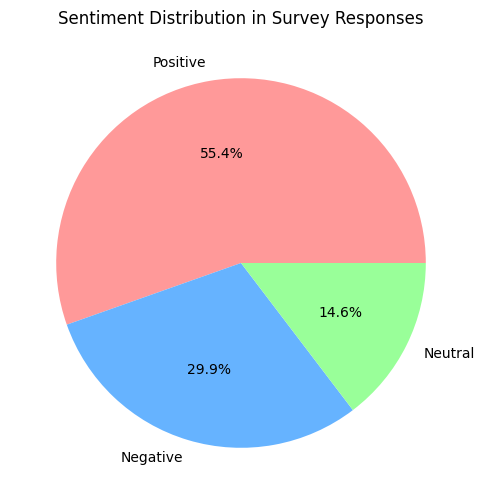

In [127]:
# Count each sentiment label
sentiment_counts = df_text2["sentiment_label"].value_counts()

# Plot
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment Distribution in Survey Responses")
plt.show()


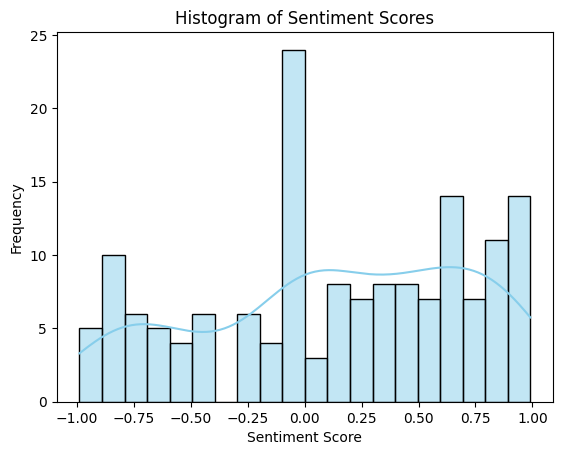

In [128]:
sns.histplot(data=df_text2, x="sentiment_score", bins=20, kde=True, color='skyblue')

plt.title("Histogram of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

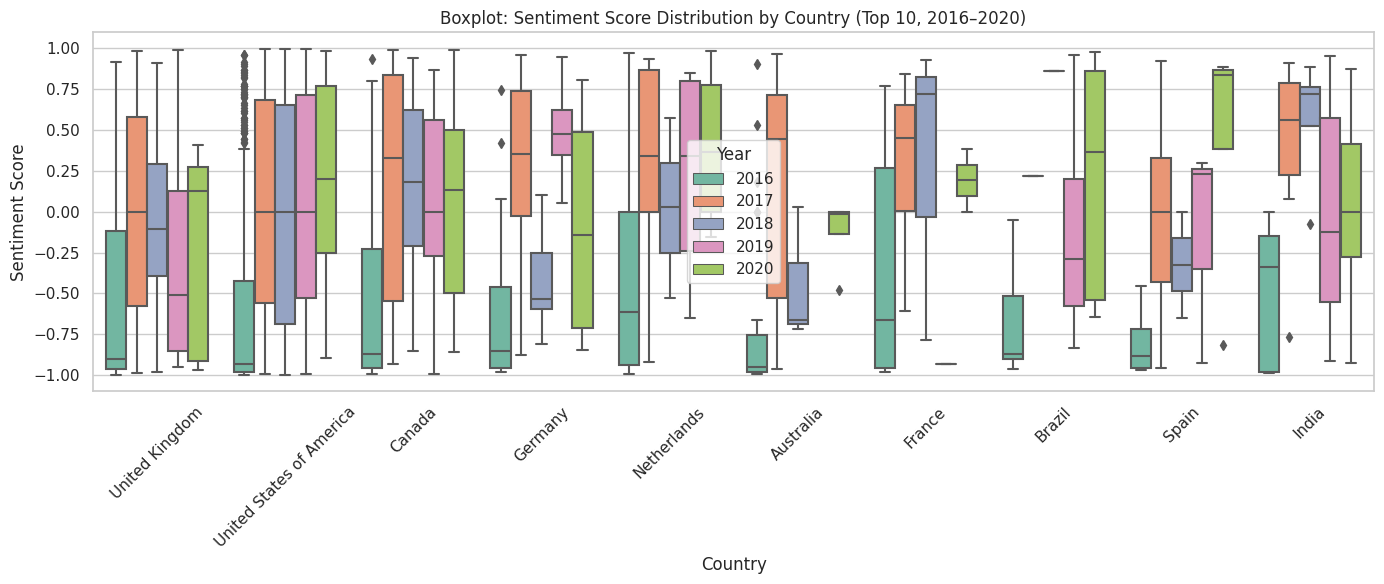

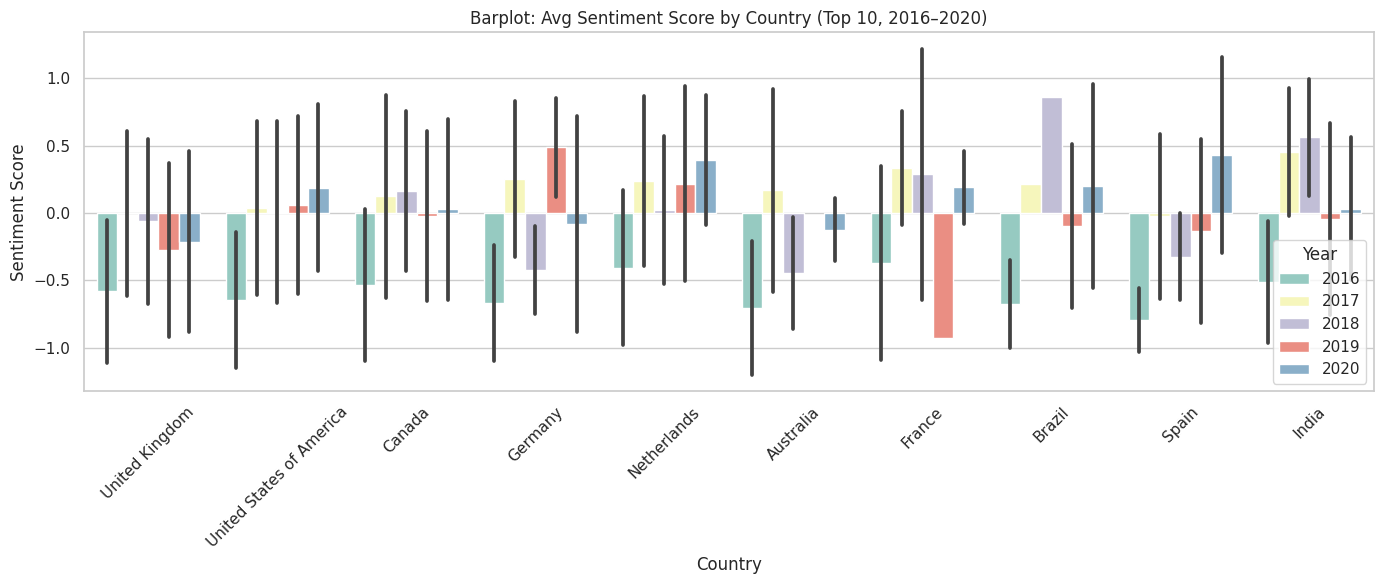

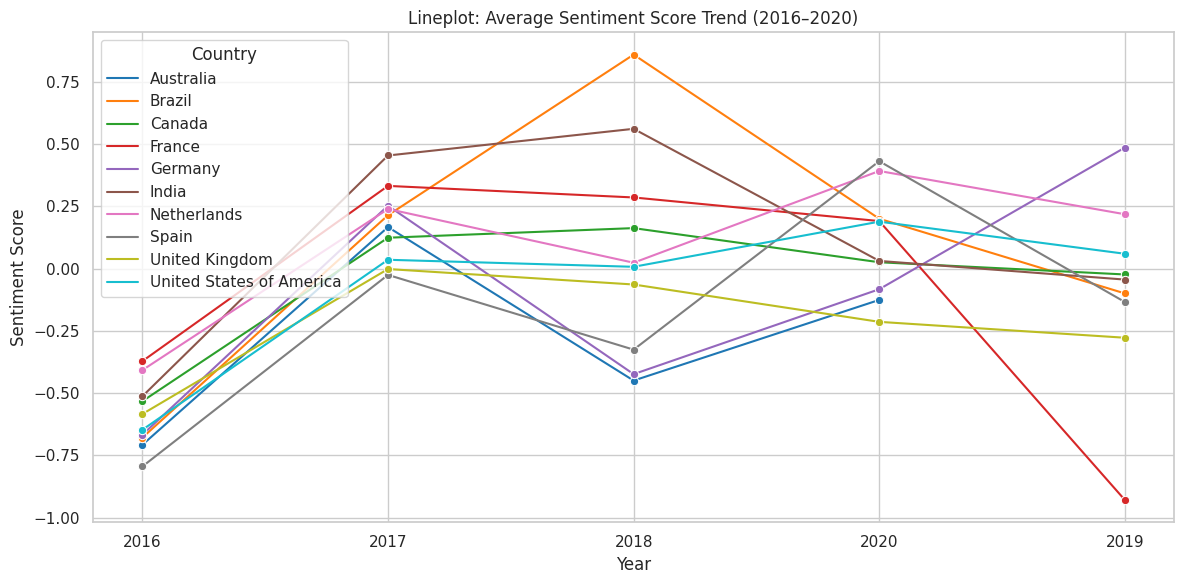

In [134]:
# Combine all data into a single DataFrame
df_combined = pd.DataFrame()

for year in range(2016, 2021):
    countries = globals()[f'country_data{year}']
    scores = globals()[f'score{year}']
    
    temp_df = pd.DataFrame({
        'Country': countries,
        'Sentiment Score': scores,
        'Year': str(year)
    })
    
    df_combined = pd.concat([df_combined, temp_df], ignore_index=True)

# Filter to Top 10 most frequent countries
top_countries = df_combined['Country'].value_counts().head(10).index
df_combined = df_combined[df_combined['Country'].isin(top_countries)]

# Set plot style
sns.set(style="whitegrid")

# 🔷 1. Boxplot: Distribution of Sentiment Scores
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_combined, x='Country', y='Sentiment Score', hue='Year', palette='Set2')
plt.title("Boxplot: Sentiment Score Distribution by Country (Top 10, 2016–2020)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 🔶 2. Barplot: Average Sentiment Score
plt.figure(figsize=(14, 6))
sns.barplot(data=df_combined, x='Country', y='Sentiment Score', hue='Year', palette='Set3', ci='sd')
plt.title("Barplot: Avg Sentiment Score by Country (Top 10, 2016–2020)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 🔷 3. Lineplot: Sentiment Trend Over Time per Country
avg_scores = df_combined.groupby(['Country', 'Year'])['Sentiment Score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_scores, x='Year', y='Sentiment Score', hue='Country', marker='o', palette='tab10')
plt.title("Lineplot: Average Sentiment Score Trend (2016–2020)")
plt.tight_layout()
plt.show()

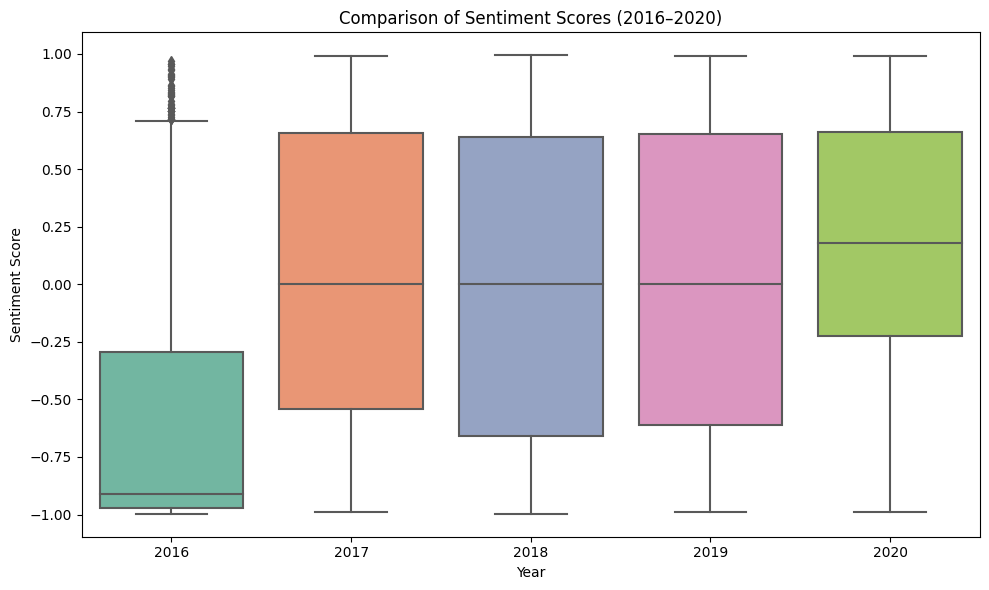

In [131]:
# Combine the scores into a DataFrame
df_scores = pd.DataFrame({
    'Year': ['2016'] * len(score2016) + ['2017'] * len(score2017) + ['2018'] * len(score2018) +
            ['2019'] * len(score2019) + ['2020'] * len(score2020),
    'Score': pd.concat([score2016, score2017, score2018, score2019, score2020], ignore_index=True)
})

# Create a box plot for comparing sentiment scores across years
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_scores, x='Year', y='Score', palette='Set2')

# Adding titles and labels
plt.title("Comparison of Sentiment Scores (2016–2020)")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()